# Distributed processing to obtain graphs from all simulations

In [1]:
import readfof
from pyspark.sql import SparkSession
import numpy as np
import matplotlib.pyplot as plt
import math

### Spark cluster

In [2]:
spark = SparkSession.builder \
        .master("spark://master:7077")\
        .appName("CosmoSparkApplication")\
        .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/05 15:45:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
sc = spark.sparkContext

### Useful functions

In [4]:
# Read data
def read_cosmo_data(file_path):

    # Read Fof
    FoF = readfof.FoF_catalog(
        file_path,           # simulation directory
        2,                   # snapnum, indicating the redshift (z=1)
        long_ids = False,
        swap = False,
        SFR = False,
        read_IDs = False
        )

    return FoF


# Get masses and positions from FoF
def get_pos_mass(FoF):

    pos = FoF.GroupPos/1e06             # Halo positions in Gpc/h 
    mass_raw = FoF.GroupMass * 1e10     # Halo masses in Msun/h

    dim = pos.shape[0]
    pos_mass_matrix = np.hstack([pos, mass_raw.reshape(dim, 1)])

    return pos_mass_matrix

# To assign simulation keys to each point in each simulation
def assign_key_to_rows(key_value_pair):
    key, array = key_value_pair
    return [(key, row) for row in array]


# Plot a graph in 3D space
def plot_graph_3D(num, pars_file, pos, masses, edge_idx):

    fig = plt.figure(figsize=(10, 10))
    fontsize = 12

    ax = fig.add_subplot(projection ="3d")

    pos = np.array(pos, dtype=float) * 1.e3   # show in Mpc

    # Draw lines for each edge
    for (src, dst) in edge_idx: #.t().tolist():

        src = pos[int(src)].tolist()
        dst = pos[int(dst)].tolist()

        ax.plot([src[0], dst[0]], [src[1], dst[1]], zs=[src[2], dst[2]], linewidth=0.6, color='dimgrey')

    # Plot nodes
    mass_mean = np.mean(masses)
    for i,m in enumerate(masses):
            ax.scatter(pos[i, 0], pos[i, 1], pos[i, 2], s=50*m*m/(mass_mean**2), zorder=1000, alpha=0.6, color = 'mediumpurple')

    ax.xaxis.set_tick_params(labelsize=fontsize)
    ax.yaxis.set_tick_params(labelsize=fontsize)
    ax.zaxis.set_tick_params(labelsize=fontsize)

    ax.set_xlabel('x (Mpc)', fontsize=16, labelpad=15)
    ax.set_ylabel('y (Mpc)', fontsize=16, labelpad=15)
    ax.set_zlabel('z (Mpc)', fontsize=16, labelpad=15)

    rl = '$R_{link} = 0.2$'

    pars_file = pars_file[num]

    ax.set_title(f'\tGraph n°{num}, Masses $\\geq 99.7$% percentile, {rl} Mpc \t \n \n $\\Omega_m = {float(pars_file[0]):.3f}$ \t $\\sigma_8 = {float(pars_file[1]):.3f}$', fontsize=20)

    plt.show()


# Graph object
class graph:

    def __init__(self, node_f, pos, sim_pars, glob_f, edge_idx, edge_f):
        
        self.node_f = node_f
        self.pos = pos
        self.sim_pars = sim_pars
        self.glob_f = glob_f
        self.edge_idx = edge_idx
        self.edge_f = edge_f


# Create graph object
def create_graph(rdd):
    sim_graph = graph(
        np.array(rdd[0])[:,3],   # node_f = masses
        np.array(rdd[0])[:,0:3], # pos
        np.array(rdd[3]),        # sim_pars
        np.array(rdd[2]),        # glob_f
        np.array(rdd[1])[:,0:2], # edge_idx
        np.array(rdd[1])[:,2:5], # edge_f
    )
    return(sim_graph)

### Read simulations and parallelize data

In [5]:
# simulations parameter
sim_pars_file = np.loadtxt("/mnt/cosmo_GNN/latin_hypercube_params.txt", dtype=float)

# number of simulations to be processed
n_sims = 10

# path list with simulation keys
path_list = [(i, "/mnt/cosmo_GNN/Data/" + str(i)) for i in range(n_sims)]

# parallelize path list and read files
fof_rdd = sc.parallelize(path_list)\
            .mapValues(read_cosmo_data)

# get positions and masses for each point
pos_mass_rdd = fof_rdd.mapValues(get_pos_mass)\
                      .flatMap(assign_key_to_rows)

# cut percentile
cut = 0.997

# get mass cuts 
mass_cut_rdd = fof_rdd.mapValues(get_pos_mass)\
                      .mapValues(lambda x: np.quantile(x[:, -1], cut))

mass_cuts = mass_cut_rdd.values().collect()
mass_cuts = np.array(mass_cuts)

# filter by mass
pos_mass_rdd_filtered = pos_mass_rdd.filter(lambda x: x[1][-1] >= mass_cuts[x[0]])

# number of halos in each simulation
n_halos = pos_mass_rdd_filtered.countByKey()

In [6]:
pos_mass_rdd_filtered.getNumPartitions()

2

In [7]:
n_halos

defaultdict(int,
            {0: 188,
             1: 641,
             2: 248,
             3: 517,
             4: 449,
             5: 681,
             6: 220,
             7: 222,
             8: 478,
             9: 179})

In [8]:
# number of halo distribution

In [10]:
# mass cut distribution
# mass_cut_rdd.histogram() # --> TO DO

### Clustering phase to get linked halos

In [11]:
# masses rdd
mass_rdd = pos_mass_rdd_filtered.mapValues(lambda x: x[3])

# positions rdd
pos_rdd = pos_mass_rdd_filtered.mapValues(lambda x: x[:3])

# indexed positions rdd (point indexes)
# --> ( simkey, (point_idx, array(x, y, z)) )
idx_pos_rdd = pos_rdd.groupByKey()\
                     .flatMapValues(lambda vals: enumerate(vals))

# obtain all the possible point pairs for each simulation 
# --> ( (simkey, (idx, array)), (simkey, (idx, array)) )
# then take only pairs in the same simulation
cartesian_rdd = idx_pos_rdd.cartesian(idx_pos_rdd)\
                           .filter(lambda x: x[0][0] == x[1][0]) 

# compute differences between every pair 
# --> (simkey, (idx1, idx2, coord1, coord2, diff_coord))
diff_rdd = cartesian_rdd.map(lambda x: (x[0][0], (x[0][1][0], x[1][1][0], x[0][1][1], x[1][1][1], x[0][1][1] - x[1][1][1] )))

# compute distances between every pair
# --> (sim_key, (idx1 idx2, coord1, coord2, diff_coord, distance))
pairs_dist_rdd = diff_rdd.mapValues(lambda x: (x[0], x[1], x[2], x[3], x[4], np.linalg.norm(x[4]))) 

# pairs and distances rdd filtered (by linking radius)
linked_pairs_dist_rdd = pairs_dist_rdd.filter(lambda x: x[1][-1] <= 0.2)

# pairs rdd --> (simkey, (idx1, idx2)) --> reverse pair already included
pairs_rdd = linked_pairs_dist_rdd.mapValues(lambda x: (x[0], x[1]))

In [12]:
# pairs in each simulation before (fixed - radius) clustering 
pairs_dist_rdd.countByKey()

defaultdict(int,
            {0: 35344,
             2: 61504,
             4: 201601,
             6: 48400,
             8: 228484,
             5: 463761,
             7: 49284,
             9: 32041,
             1: 410881,
             3: 267289})

In [13]:
# pairs in each simulation after (fixed - radius) clustering 
linked_pairs_dist_rdd.countByKey()

defaultdict(int,
            {6: 1474,
             8: 6734,
             0: 1224,
             2: 2110,
             4: 7109,
             1: 11787,
             3: 8035,
             5: 12977,
             7: 1724,
             9: 1077})

### A graph 3D plot

In [14]:
# retrieve data for a simulation to show the plot
sim_num_plot = 8
pos_mass_rdd_filtered_plot = pos_mass_rdd_filtered.filter(lambda x: x[0] == sim_num_plot)\
                                                  .map(lambda x: x[1])
pos_mass_plot = np.array(pos_mass_rdd_filtered_plot.collect())
pos_plot = pos_mass_plot[:,:3]
mass_plot = pos_mass_plot[:,3]
pairs_idx_plot = pairs_rdd.filter(lambda x: x[0] == sim_num_plot)\
                          .values()
pairs_idx_plot_array = np.array(pairs_idx_plot.collect())

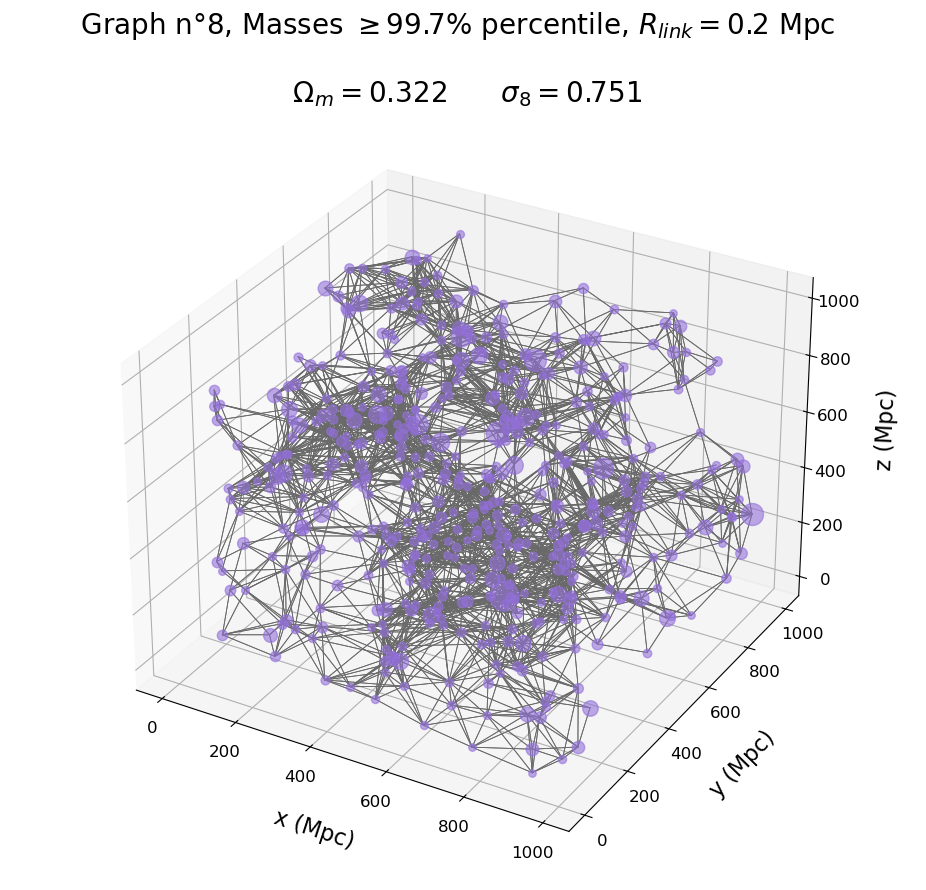

In [15]:
plot_graph_3D(sim_num_plot, sim_pars_file, pos_plot, mass_plot, pairs_idx_plot_array)

### Retrieving edge features

In [16]:
# centroids positions
halo_centroids = pos_rdd.reduceByKey(lambda x,y: (x+y)/2)

# joined rdd with halo centroids positions
joined_rdd = linked_pairs_dist_rdd.join(halo_centroids)

# distance between each point from each pair and halo centroid
row_col_diff_rdd = joined_rdd.mapValues(
    lambda x: (
        x[0][0],        # idx_i
        x[0][1],        # idx_j
        x[0][2] - x[1], # row
        x[0][3] - x[1], # col
        x[0][4],        # diff
        x[0][5]         # dist
        ))

# normalizing 
normalized_rdd = row_col_diff_rdd.mapValues(
    lambda x: (
        x[0],                      # idx_i
        x[1],                      # idx_j
        x[2]/np.linalg.norm(x[2]), # row_normalized
        x[3]/np.linalg.norm(x[3]), # col_normalized
        x[4]/np.linalg.norm(x[4]), # s_ij
        x[5]/0.2                   # |d_ij|/r 
    )
)

# edge attributes
edge_attr_rdd = normalized_rdd.mapValues(
    lambda x: (
        x[0],
        x[1],
        np.dot( x[2].T, x[3] ), # cos(alpha)
        np.dot( x[2].T, x[4] ), # cos(beta)
        x[5]                    # |d_ij|/r 
    )
)

### Global features and graph objects creation

In [17]:
# group by simulation
grouped_idx_pos_rdd = pos_mass_rdd_filtered.groupByKey()\
                                 .mapValues(list)

grouped_edge_rdd = edge_attr_rdd.groupByKey()\
                                .mapValues(list)

# parallelize simulation parameters file and global features
param_rdd = sc.parallelize([(i, el) for i, el in enumerate(sim_pars_file)])
u = sc.parallelize([(i[0], math.log10(i[1])) for i in n_halos.items()])

# graph rdd (a graph for each simulation)
# masses, positions, simulation parameters, global features, edge indexes, edge features
raw_graph_rdd = grouped_idx_pos_rdd.join(grouped_edge_rdd)\
                                   .join(u)\
                                   .join(param_rdd)\
                                   .mapValues(lambda x: (x[0][0][0], x[0][0][1], x[0][1], x[1]))

# creating graph rdd
graph_rdd = raw_graph_rdd.mapValues(lambda x: create_graph(x))   

In [18]:
# counting graphs
graph_rdd.count()

10

In [19]:
# explore graph attributes
graph_rdd.take(10)[8][1].node_f

array([7.2134815e+14, 5.5314266e+14, 5.4184032e+14, 5.3918093e+14,
       5.0793317e+14, 4.9929032e+14, 4.8399819e+14, 4.5141975e+14,
       4.3613017e+14, 4.3413563e+14, 4.3214109e+14, 4.2615749e+14,
       4.1352546e+14, 4.0754186e+14, 4.0288796e+14, 4.0089312e+14,
       3.9490983e+14, 3.9158552e+14, 3.9158562e+14, 3.8959108e+14,
       3.8759657e+14, 3.8626688e+14, 3.8560139e+14, 3.8094813e+14,
       3.7496454e+14, 3.7429969e+14, 3.7164030e+14, 3.6831609e+14,
       3.6831609e+14, 3.6565670e+14, 3.6432704e+14, 3.6299859e+14,
       3.6233250e+14, 3.6033796e+14, 3.5967311e+14, 3.5967311e+14,
       3.5834345e+14, 3.5568406e+14, 3.5169501e+14, 3.4438172e+14,
       3.4371687e+14, 3.4172233e+14, 3.3906297e+14, 3.3906297e+14,
       3.3573873e+14, 3.2443649e+14, 3.2377168e+14, 3.2377168e+14,
       3.2310687e+14, 3.2111239e+14, 3.1911792e+14, 3.1845310e+14,
       3.1180483e+14, 3.1180483e+14, 3.1180489e+14, 3.0981039e+14,
       3.0848076e+14, 3.0781591e+14, 3.0715106e+14, 3.0582237e

### Stop Spark Context and Master

In [20]:
sc.stop()
spark.stop()